Tutorial - Part #2 - Spatially variant PSF
=======================


### Introduction

This package hosts a simple implementation of the proposed technique by Lauer 2002.

The technique performs a linear decomposition of the PSF into several *basis* elements of small
size (much smaller than the image) normalized to unit sum. 
Each of these *autopsfs* come with a coefficient, which is not normalized, that have the same size of the image.

To perform the decomposition uses the *Karhunen-Loeve* transform,
in order to calculate the *basis* as a linear expansion of the 
*psf observations* --which are cutout stamps of the stars in the image.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from properimage import simtools
from properimage import single_image as si

#### We simulate an image with several star shapes across the field

In [3]:
frames = []
for theta in [0, 45, 105, 150]:
    N = 512  # side
    X_FWHM = 5 + 6.5*theta/180
    Y_FWHM = 5
    t_exp = 5
    max_fw = max(X_FWHM, Y_FWHM)
    #test_dir = os.path.abspath('./test/test_images/psf_basis_kl_gs')

    x = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
    y = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
    xy = [(x[i], y[i]) for i in range(80)]

    SN =  30. # SN para poder medir psf
    weights = list(np.linspace(10, 1000., len(xy)))
    m = simtools.delta_point(N, center=False, xy=xy, weights=weights)
    im = simtools.image(m, N, t_exp, X_FWHM, Y_FWHM=Y_FWHM, theta=theta,
                        SN=SN, bkg_pdf='gaussian')
    frames.append(im+100.)

In [4]:
frame = np.zeros((1024, 1024))
for j in range(2):
    for i in range(2):
        frame[i*512:(i+1)*512, j*512:(j+1)*512] = frames[i+2*j]

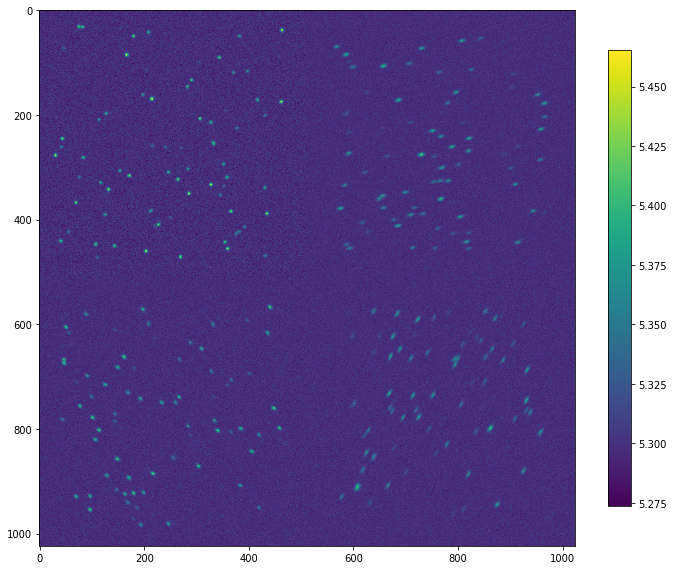

In [5]:
plt.figure(figsize=(12, 12))
plt.imshow(np.log(frame), interpolation='none')
plt.colorbar(shrink=0.7)

#### We perform the psf extraction. 

This is possible to do with a context manager, in order to *autoclean* the disk files where the star stamps are stored.

In [6]:
%%time

with si.SingleImage(frame, smooth_psf=False) as sim:
    a_fields, psf_basis = sim.get_variable_psf(inf_loss=0.15)
    x, y = sim.get_afield_domain()

updating stamp shape to (25,25)


CPU times: user 1.74 s, sys: 277 ms, total: 2.01 s
Wall time: 1.14 s


In [7]:
print(len(psf_basis))

3


This is equivalent to do the following:

In [8]:
sim = si.SingleImage(frame, smooth_psf=False)
a_fields, psf_basis = sim.get_variable_psf(inf_loss=0.15)
x, y = sim.get_afield_domain()

updating stamp shape to (25,25)


In this case, we will have the `sim` object in memory and we need to close it to erase the auxiliary files being generated.

#### We can peek into the variable PSF

The *autopsf* elements are small patches, like the ones below.

The principal component psf is the first element of this list of arrays.

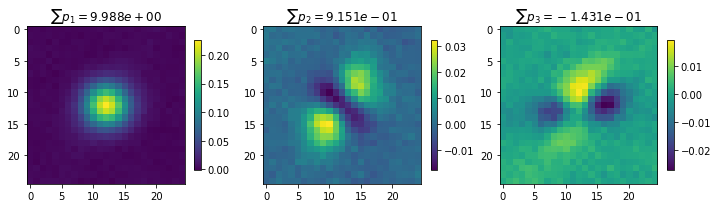

In [9]:
ax = sim.plot.autopsf()

We can also plot the coefficients, they look as smooth fields of the same size of the image. 

Whenever they grow they show where the corresponding *autopsf* element is more important than others.

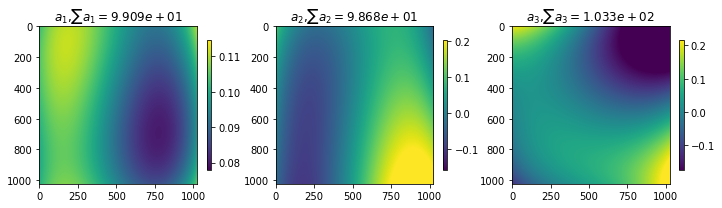

In [10]:
ax = sim.plot.autopsf_coef()

## Rebuilding an image frame
In order to obtain the PSF value on any place of the image, we need to perform the summation of
the *autopsf* elements weighted by the *afields* in the particular position we may desire.

In [11]:
loc = (880, 995)

PSF_loc = np.zeros_like(psf_basis[0])
for apsf, afield in zip(psf_basis, a_fields):
    PSF_loc += apsf * afield(*loc)

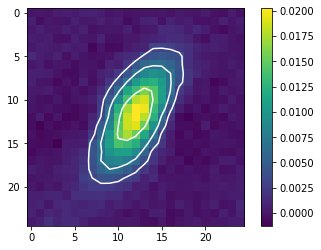

In [12]:
levels = np.logspace(-2.5, -0.5, num=7) 

plt.imshow(PSF_loc)
plt.colorbar()
plt.contour(PSF_loc, levels=levels, cmap='Greys')

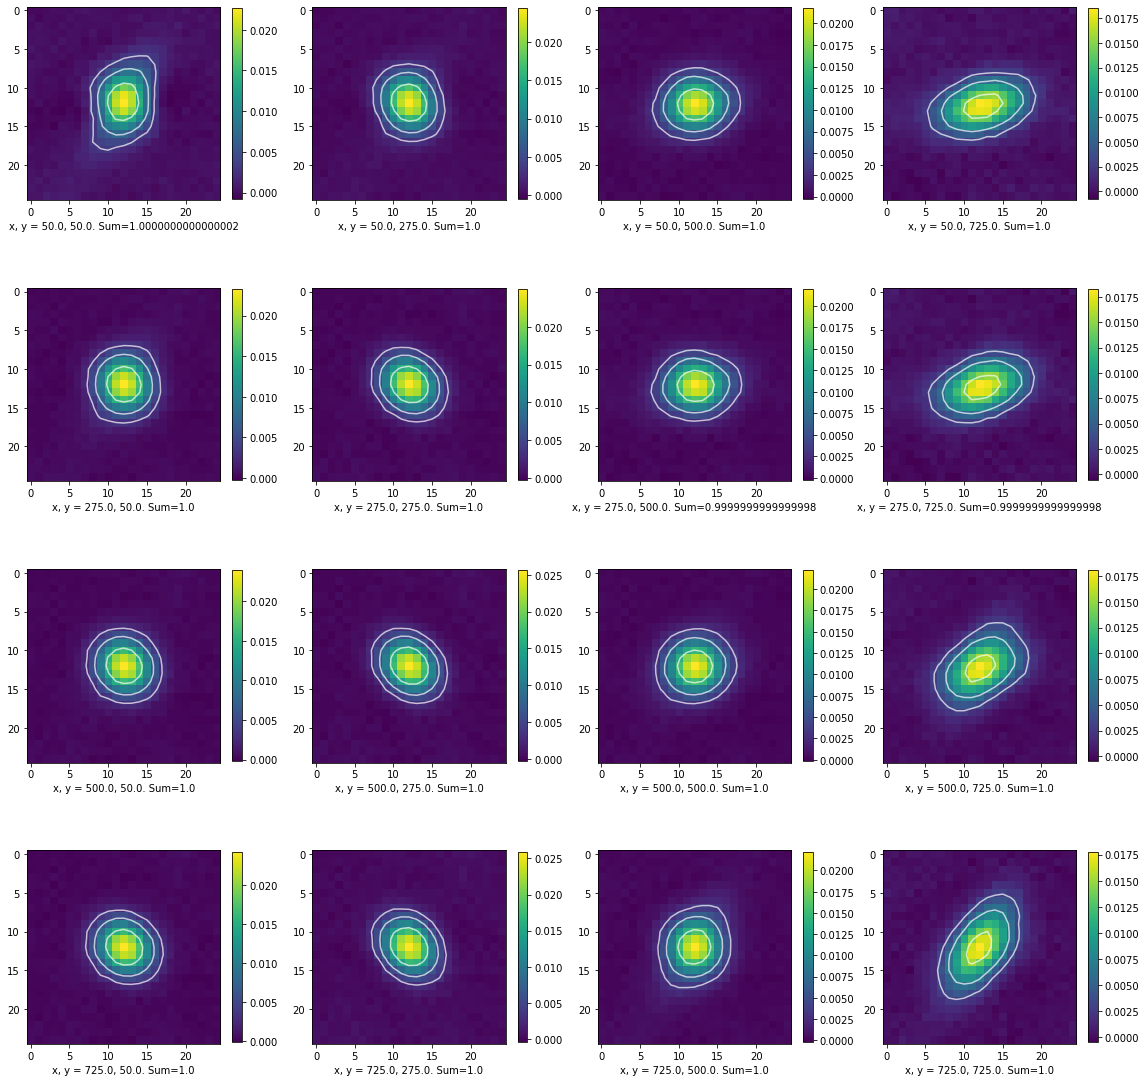

In [13]:
xs = np.repeat(np.arange(50, 950, 900/4), 4)
ys = np.array([np.repeat(50+i*900/4., 4) for i in range(4)]).T.flatten()

i = 0
plt.figure(figsize=(16, 16))
for xp, yp in zip(xs, ys):
    PSF_loc = sim.get_psf_xy(xp, yp)
    plt.subplot(4, 4, i+1)
    plt.imshow(PSF_loc/np.sum(PSF_loc))
    plt.colorbar(shrink=0.7)
    plt.contour(PSF_loc, cmap='Greys', alpha=0.7, levels=levels)
    plt.xlabel('x, y = {}, {}. Sum={}'.format(np.round(xp), np.round(yp), np.sum(PSF_loc)))
    i += 1
plt.tight_layout()